In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECKPOINT_DIR
from cot.models import TransformerConfig, Transformer

In [18]:
problem = Parity
n_len=16
emb_dim=128
n_head=1
n_layer=2
device='cuda'

In [4]:
%run ../src/cot/grid_run.py --n_len 32 --max_nb_data_per_len 1000 --n_head 1 --n_layer 2 --n_epochs 4000 --n_len 16 --batch_size 4096 --emb_dim 128 --load_checkpoint False --problem parity

05-13 15:51:00 INFO [data_processing.py:92] Generating data. Saving in /private/home/vivc/code/llm/cot/data/parity
05-13 15:51:00 INFO [data_processing.py:136] Loading data from /private/home/vivc/code/llm/cot/data/parity.
05-13 15:51:00 INFO [data_processing.py:136] Loading data from /private/home/vivc/code/llm/cot/data/parity.
05-13 15:51:00 INFO [train.py:132] Problem: parity. Number of training data: 7167.


05-13 15:51:02 INFO [train.py:159] Device used: cuda:0.
/private/home/vivc/code/llm/cot/src/cot/evals/cot.py:200: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  attn_inv[i, 0] = 1 - attn0.std(dim=0).mean()
/private/home/vivc/code/llm/cot/src/cot/evals/cot.py:201: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  attn_inv[i, 1] = 1 - attn1.std(dim=0).mean()
05-13 15:51:03 INFO [train.py:209] Starting Training from epoch 0.
05-13 15:51:03 INFO [train.py:238] Epoch     1, Loss: 1.9747
05-13 15:51:03 INFO [train.py:238] Epoch     2, Loss: 0.9901
05-13 15:51:03 INFO [train.py:238] Epoch     3, Loss: 0.8445
05-13 15:51:04 INFO [train.py:238] Epoch     4, 

KeyboardInterrupt: 

## Looking at the evaluation metrics

In [19]:
path = CHECKPOINT_DIR / problem.prefix / 'model.pth'
path = '/private/home/vivc/code/llm/cot/models/1715615460/model.pth'

checkpoint = torch.load(path)

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

evals = checkpoint['evals'][ind]
eval_dim = evals.shape[1] // 2

meaning = checkpoint['meaning']
assert len(meaning) == eval_dim

In [20]:
acc_by_len = evals[:, :n_len]
test_acc_by_len = evals[:, eval_dim:eval_dim + n_len]
spe_acc = evals[:, n_len:n_len + 3]
test_spe_acc = evals[:, eval_dim + n_len:eval_dim + n_len + 3]

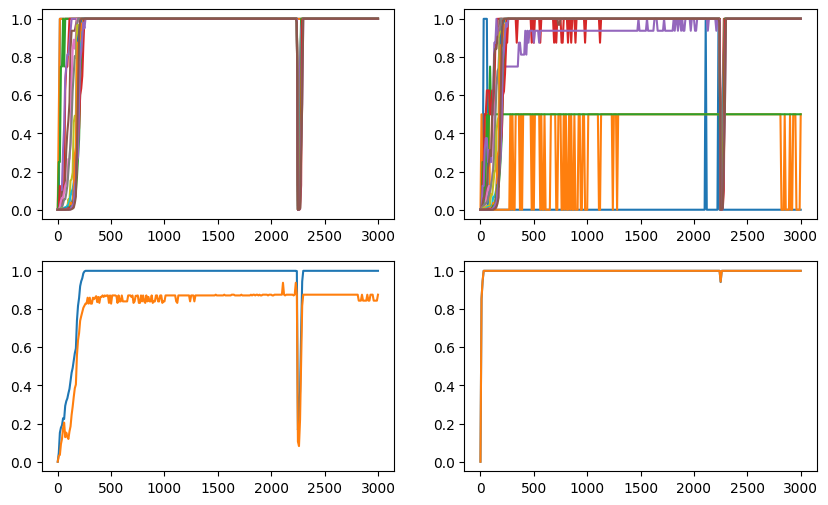

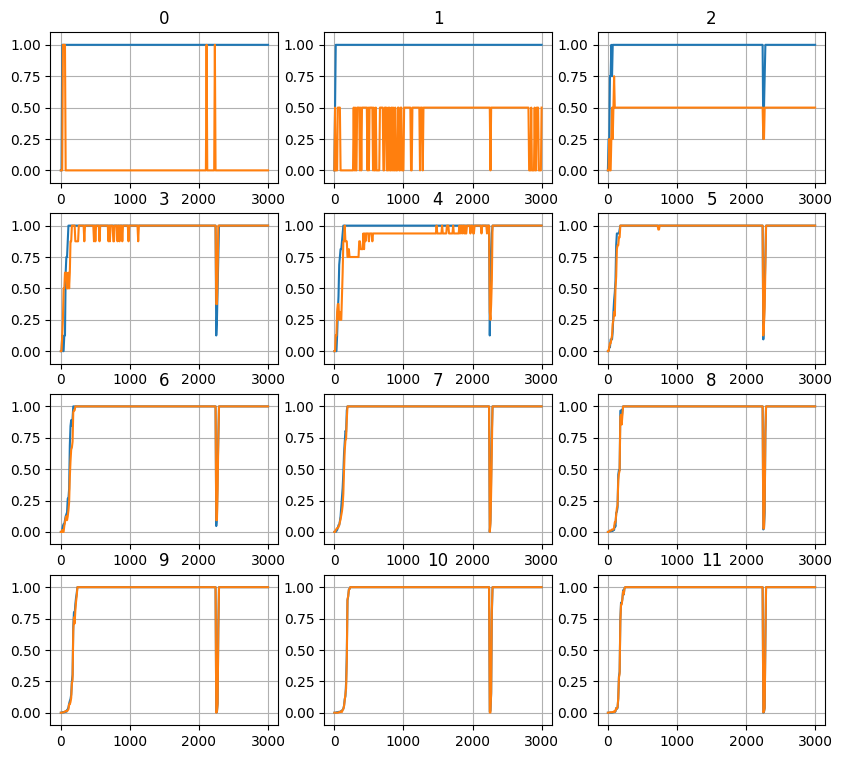

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(timestamps, acc_by_len)
axes[0, 1].plot(timestamps, test_acc_by_len)
axes[1, 0].plot(timestamps, acc_by_len.mean(axis=1))
axes[1, 0].plot(timestamps, test_acc_by_len.mean(axis=1))
axes[1, 1].plot(timestamps, spe_acc[:, 2])
axes[1, 1].plot(timestamps, test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

n_len = 12
fig, axes = plt.subplots(n_len // 3 + (1 if n_len % 3 else 0), 3, figsize=(10, 9))
for i in range(n_len):
    axes[i // 3, i % 3].plot(timestamps, acc_by_len[:, i])
    axes[i // 3, i % 3].plot(timestamps, test_acc_by_len[:, i])
    axes[i // 3, i % 3].set_ylim(-.1, 1.1)
    axes[i // 3, i % 3].set_title(i)
    axes[i // 3, i % 3].grid()

## Check for meaning correctness

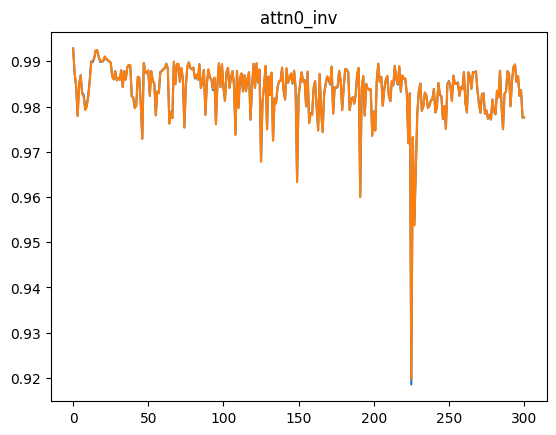

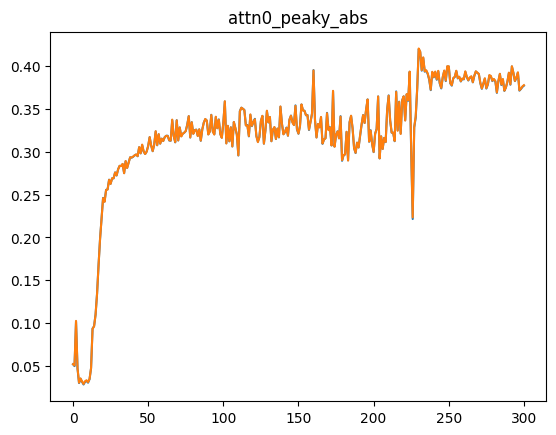

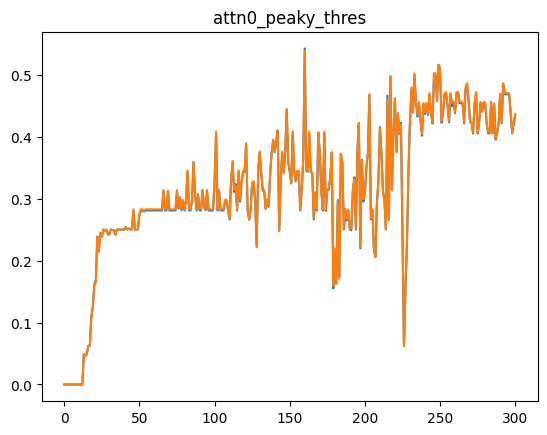

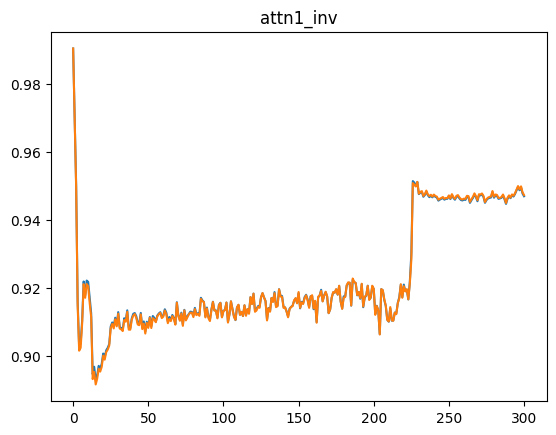

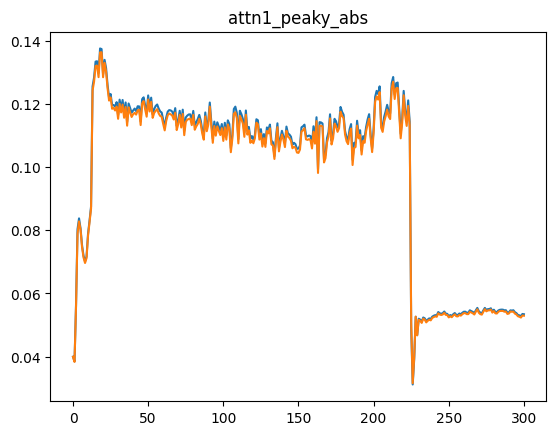

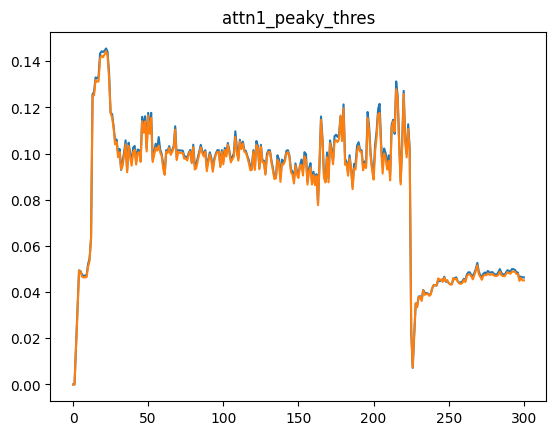

In [22]:
for eval in ['attn0_inv', 'attn0_peaky_abs', 'attn0_peaky_thres', 'attn1_inv', 'attn1_peaky_abs', 'attn1_peaky_thres']:
    ind = np.zeros(len(meaning), dtype=bool)
    for i, stri in enumerate(meaning):
        if stri.startswith(eval):
            ind[i] = True
    train_ind = np.hstack((np.zeros_like(ind), ind))
    train_tmp = evals[:, train_ind]
    test_ind = np.hstack((ind, np.zeros_like(ind)))
    test_tmp = evals[:, test_ind]
    fig, ax = plt.subplots()
    ax.plot(train_tmp[:, -1])
    ax.plot(test_tmp[:, -1])
    ax.set_title(eval)

## Looking at the model

In [23]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

In [28]:
n_len = 16
lengths = list(np.arange(n_len) + 1)

testset = problem()
testset.set_data(lengths, data_type="test")

05-13 16:06:20 INFO [data_processing.py:136] Loading data from /private/home/vivc/code/llm/cot/data/parity.


In [29]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=emb_dim,
    pos_emb=True,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=n_head,
    n_layer=n_layer,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(35, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=5, bias=False)
)

In [30]:
sequence = testset.data
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)

We can extract the attention scores that we would like to maximize.

In [37]:
i = 2**10
seq = sequence[-1]
attn0 = attentions[0, i, 0].cpu()
attn1 = attentions[1, i, 0].cpu()

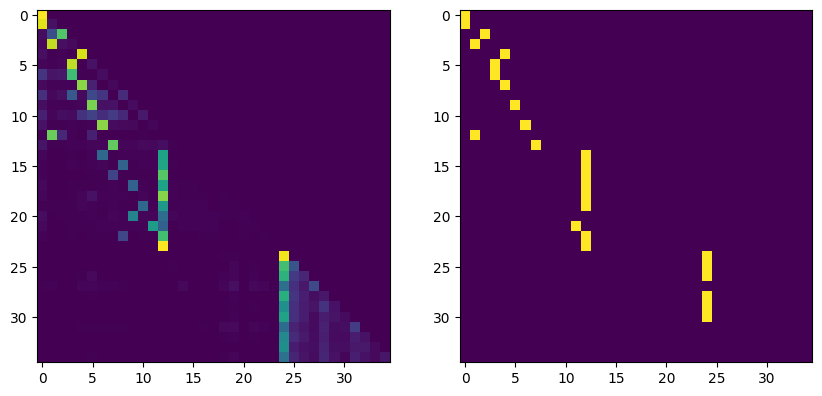

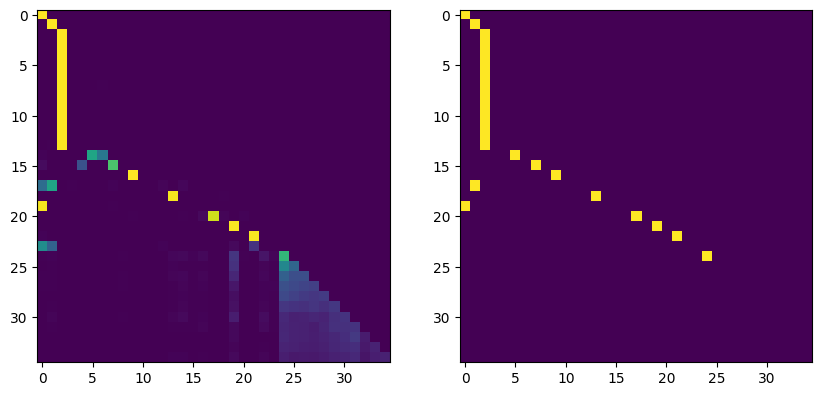

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn0)
axes[1].imshow(attn0 > .5)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn1)
axes[1].imshow(attn1 > .5)